# Biodiversity Data From the National Parks Service

## Project Goals

For this project, as we are looking through the lens of a biodiversity analyst for the National Park Service, the goal is to understand the National Parks and its animals.
To do so, we try to answer different questions as:
    
* What is the distribution of conservation status for species?
* Are certain types of species more likely to be endangered?
* Are the differences beetween species and their conservation status significant?
* Which animal is most prevalent and what is their distribution amongst parks?

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
species = pd.read_csv("species_info.csv")
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [3]:
observations = pd.read_csv("observations.csv")
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


## Exploring Data

In [4]:
species.shape

(5824, 4)

In [5]:
observations.shape

(23296, 3)

In [6]:
#observing the species data a bit more

species.nunique()

category                  7
scientific_name        5541
common_names           5504
conservation_status       4
dtype: int64

In [7]:
# see which different species are listed

species.category.unique()

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

In [8]:
# how are the categorys distributed

species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [9]:
# exploring conservation status

print("number of conservations status: "+ str(species.conservation_status.nunique())) 
print("unique conservation status: ") 
print(species.conservation_status.unique())

number of conservations status: 4
unique conservation status: 
[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [10]:
# determine the amount of nan conservation statuses
print("Na values:" + str(species.conservation_status.isna().sum()))


Na values:5633


In [11]:
species.groupby("conservation_status").size()

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64

In [12]:
# next is the observations data

print("number of parks:" + str(observations.park_name.nunique()))
print("unique parks:")
print(observations.park_name.unique())

number of parks:4
unique parks:
['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [13]:
print("number of observations: " +str(observations.observations.sum()))

number of observations: 3314739


## Analysis

Conservation_status has these possible values:

* Species of Concern: appear to be in need of conservation
* Threatened: endangered in the near future
* Endangered: seriously at risk of extinction
* In Recovery: used to be endangered but not anymore

While exploring the data, many NaN values were detected in the conservation_status.
This is why they need to be handled.
In the following these nan-values will be changed to "No Intervention"

In [14]:
species.fillna("No Intervention", inplace = True)
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

Now we will take a look at how the species are distributed throughout the different conservation status except for the ones that do not need Intervention

In [15]:
conservation_category = species[species.conservation_status!="No Intervention"].groupby(["conservation_status", "category"])["scientific_name"].count().unstack()

conservation_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Text(0, 0.5, 'Number of Species')

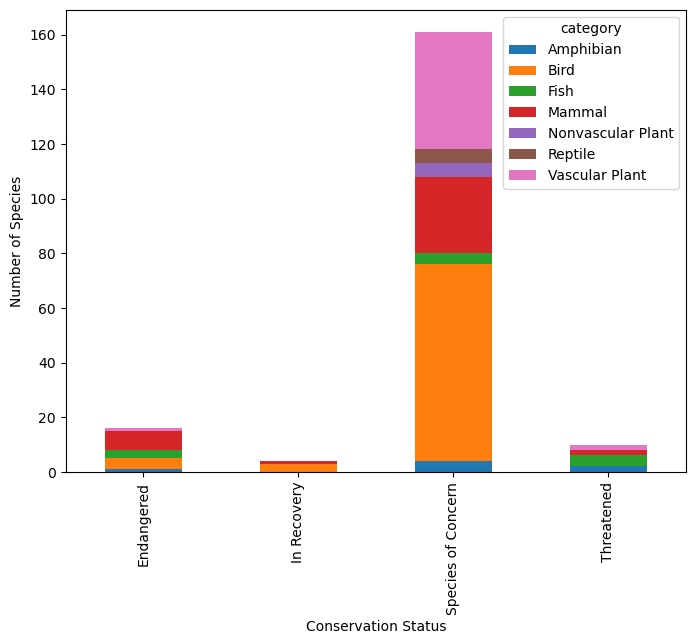

In [16]:
conservation_plot = conservation_category.plot(kind= "bar", figsize=(8,6), stacked = True)

conservation_plot.set_xlabel("Conservation Status")
conservation_plot.set_ylabel("Number of Species")

Are any species more likely to be endangered? This will be answered by creating a new column called is_protected and will include any species with a value other than No Intervention.

In [17]:
species["is_protected"] = species.conservation_status != "No Intervention"

In [18]:
category_counts = species.groupby(["category", "is_protected"]).scientific_name.nunique().reset_index().pivot(columns="is_protected",index="category",values="scientific_name").reset_index()

category_counts.columns = ["category", "not_protected", "protected"]

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


It is to see that Birds, Mammals and Visular Plants have higher counts of protected species. However one should calculate the proportions of each category to get a clearer outlook on the actual situation.

In [19]:
category_counts["percent_protected"] = category_counts.protected/(category_counts.protected + category_counts.not_protected)*100
category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


### Statistical Significance

In this section some chi-squared tests will be run in order to see if different species have significant differences in conservation status rates. The contingency table should look like this: 

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

The first test will be called contingency1. 

In [20]:
from scipy.stats import chi2_contingency

contingency1 = [[30,146], [75, 413]]

chi2_contingency(contingency1)

(0.1617014831654557,
 0.6875948096661336,
 1,
 array([[ 27.8313253, 148.1686747],
        [ 77.1686747, 410.8313253]]))

The results return a p-value of 0.69. This is a much larger value than the standard p-value to test statistical significance which is 0.05. This ultimately shows that there is no significant relationship in the case of mammals and birds.

In the next step the difference between Reptile and Mammal will be tested.
The format will be:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Reptile|?|?|

The second test will be called contingency2.

In [21]:
contingency2 = ([30,146], [5,73])

chi2_contingency(contingency2)

(4.289183096203645,
 0.03835559022969898,
 1,
 array([[ 24.2519685, 151.7480315],
        [ 10.7480315,  67.2519685]]))

The results return a p-value of 0.038 which is below the standard p-value of 0.05 which shows a statistical significance between reptile and mammal. Mammals show a statistically significant higher rate of needed protection compared with Reptiles.

### Species in Parks

Now we will look at the common names from species to get an idea of the most prevelant animals in the dataset. This will be split up into individual names.

In [22]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    return text

commonNames = species[species.category == "Mammal"].common_names.apply(remove_punctuations).str.split().tolist()

commonNames[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

Now duplicate words in each row will be cleaned up since they should not be counted more than once for each species.

In [23]:
cleanRows = []

for item in commonNames:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)

cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [24]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))

res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [27]:
wordsCounted = []

for i in res:
    x = res.count(i)
    wordsCounted.append((i,x))

pd.DataFrame(set(wordsCounted), columns=["Word", "Count"]).sort_values("Count", ascending = False).head(10)

,Word,Count
172,Bat,23
35,Shrew,18
105,Myotis,17
61,Mouse,16
46,Chipmunk,13
112,American,12
173,Squirrel,12
9,Vole,11
92,Eastern,11
1,Mountain,10


After counting the occurences of each word, it seems that Bat occured 23 times while Shrew came up 18 times.

In the data, there are several scientific names for different types of bats. Now we will figure out which rows of species are referring to bats.

In [30]:
species["is_bat"] = species.common_names.str.contains(r"\bBat\b", regex = True)

species.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


In [31]:
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


In [32]:
batObservations = observations.merge(species[species.is_bat])

batObservations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


We have now created a DataFrame which merged the results of the bat species with the observations of bats across the four national parks.


In [35]:
batObservations.groupby("park_name").observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


The total number of bats observed in each park over the past 7 days are listed in the table above. Yellowstone shows the largest number with 8,362 while Great Smoky Mountains shows the lowest number with 2,411.

Now we will look at each park broken down by protected bats vs. non-protected bats. 

In [37]:
obs_by_park = batObservations.groupby(["park_name", "is_protected"]).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


The table shows that every park except the Great Smoky Mountains hat more sightings of protected bats than not. Which could be considered a great sign for bats.

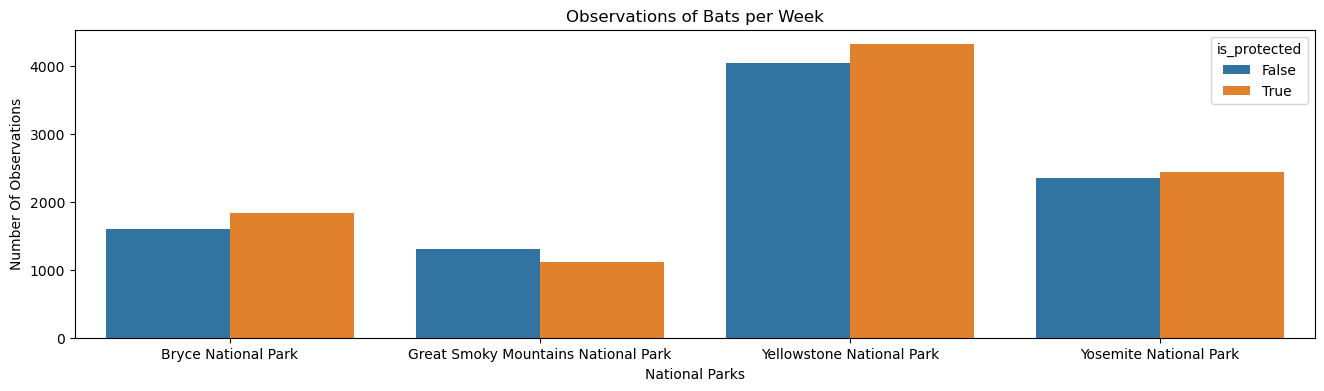

In [39]:
plt.figure(figsize=(16,4))

sns.barplot(x=obs_by_park.park_name, y=obs_by_park.observations, hue=obs_by_park.is_protected)

plt.xlabel("National Parks")
plt.ylabel("Number Of Observations")
plt.title("Observations of Bats per Week")

plt.show()

The shown plot shows that Yellowstone and Bryce National Parks seem to be doing a great job with their bat populations since there are more sightings of protected bats compared to non-protected species. The Great Smoky National Park might need to amp up there efforts in conservation as they have seen more non-protected species.